In [ ]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy

In [42]:
#load files from LogosInTheWild directory with logo categories given by their subfolder name
data = load_files('data')
logo_files = numpy.array(data['filenames'])
jpg_indices = [index for index, name in enumerate(logo_files) if 'png'==name.split('.')[-1]]
logo_targets = np_utils.to_categorical(numpy.array(data['target']), max(data['target']+1))
all_files, all_targets = logo_files[jpg_indices], logo_targets[jpg_indices]

In [43]:
from sklearn.model_selection import train_test_split

#split into 80% training+validation files+labels, and 20 % test files+labels
train_and_val_files, test_files, train_and_val_targets, test_targets = train_test_split(all_files, all_targets, test_size=0.2, random_state=0)
#further split into 80% training files+labels, and 20 % validation files+labels
train_files, val_files, train_targets, val_targets = train_test_split(train_and_val_files, train_and_val_targets, test_size=0.2, random_state=0)

#create a checkpointer to save the CNN model with the best weight parameters
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='saved_keras_models/weights.best.CNN.hdf5',
                               save_best_only=True)

In [44]:
from keras.preprocessing import image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def path_to_tensor(img_path):
    # loads RGB image as PIL format with 224x224 pixels
    img = image.load_img(img_path, target_size=(224, 224))
    # convert to 3D tensor with shape (224, 224, 3) with 3 RGB channels
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return it
    return numpy.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in img_paths]
    #stack the (1,224,224,3) 4D tensor arrays to a (# images,224,224,3) 4D tensor
    return numpy.vstack(list_of_tensors)

#create 4D tensors and rescale each pixel by dividing by RGB max value 255
train_tensors = paths_to_tensor(train_files).astype('float32')/255
val_tensors = paths_to_tensor(val_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

In [45]:
train_targets.shape

(79, 5)

In [46]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense
from keras.models import Sequential

cnn_model = Sequential()

#after the input layer, add the first convolutional layer with 32 2x2-filters
cnn_model.add(Conv2D (kernel_size = (3,3), filters = 32,
                      input_shape=train_tensors.shape[1:], activation='relu'))
#add a max pooling layer with a 2x2 pooling window
cnn_model.add(MaxPooling2D(pool_size=2))
#add the second convolutional layer with 64 2x2-filters
cnn_model.add(Conv2D(kernel_size = (3,3), filters = 64, activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=2))
#add the third convolutional layer with 128 2x2-filters
cnn_model.add(Conv2D(kernel_size = (3,3), filters = 64, activation='relu'))
#add a dropout layer so that each node has a chance of 20% to be dropped when training
#cnn_model.add(Dropout(rate = 0.2))
cnn_model.add(MaxPooling2D(pool_size = 2))
#add a global average pooling layer
cnn_model.add(GlobalAveragePooling2D())
#add the final fully connected output layer with 109 node for all 109 logo classes
cnn_model.add(Dense(5, activation = 'softmax'))

cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 52, 52, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 64)               

In [ ]:
#Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#Train the model for 600 epochs
H = cnn_model.fit(train_tensors, train_targets, epochs=600,batch_size= 3 , verbose=1,
                  validation_data=(val_tensors, val_targets))

#After training, load the model with the minimal error on the validation set
#cnn_model.load_weights('saved_keras_models/weights.best.CNN.hdf5')

79/79 [==============================] - 11s 135ms/step - loss: 0.5719 - accuracy: 0.6456 - val_loss: 0.6605 - val_accuracy: 0.4000
Epoch 24/600
24/79 [========>.....................] - ETA: 6s - loss: 0.5865 - accuracy: 0.5417

KeyboardInterrupt: 

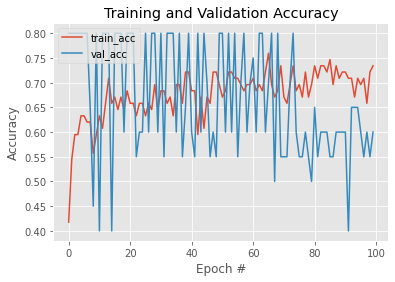

In [9]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure()
plt.plot(numpy.arange(0,100),H.history["accuracy"],label="train_acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")
plt.show()

In [10]:
print('\n', 'Test accuracy of our CNN model:', cnn_model.evaluate(test_tensors, test_targets, verbose=0)[1]*100,'%.')


 Test accuracy of our CNN model: 75.99999904632568 %.


### Prediction

['plans']


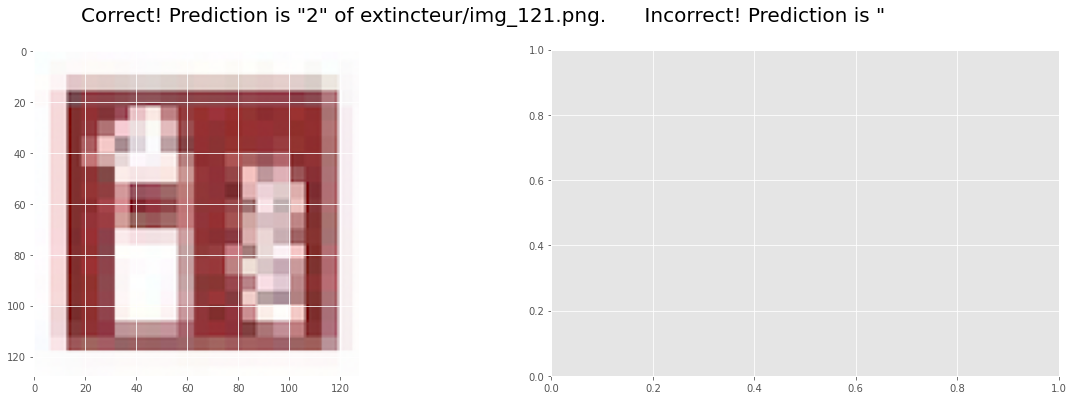

In [26]:
from glob import glob
import cv2
import matplotlib.pyplot as plt

# load list of brand names given by the subfolder names
brand_names = [item.split('/')[-2] for item in (glob("../data/plans/"))]
print(brand_names)
# get the brand name of the respective prediction of our CNN model for the respective test_tensor
brand_prediction1 = cnn_model.predict_classes(numpy.expand_dims(test_tensors[20], axis=0))[0]
#brand_prediction2 = brand_names[cnn_model.predict_classes(numpy.expand_dims(test_tensors[266], axis=0))[0]]

#save the filenames
filename1=test_files[20].split('/')[-2]+'/'+test_files[20].split('/')[-1]
#filename2=test_files[266].split('/')[-2]+'/'+test_files[266].split('/')[-1]

# load the images for plotting
img1 = cv2.imread(test_files[20])
#img2 = cv2.imread(test_files[266])
# convert BGR image to RGB for plotting
cv_rgb1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
#cv_rgb2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

#begin plotting the two images
fig = plt.figure(figsize=(20,6))
fig.add_subplot(1,2,1)
plt.imshow(cv_rgb1)
fig.add_subplot(1,2,2)
#plt.imshow(cv_rgb2)
fig.suptitle('Correct! Prediction is \"'+str(brand_prediction1)+'\" of '+filename1+'.      Incorrect! Prediction is \"', fontsize=20)
plt.show()

In [40]:
import cv2
import tensorflow as tf
#from object_detection.utils import dataset_util
from lxml import etree
import matplotlib.pyplot as plt
%matplotlib inline

#load the weights with best validation loss of the extended model from scratch with optimizer adam
#extended_model_from_scratch.load_weights('saved_keras_models/aug_extended_model_with_optimizer_adam.weights.best.hdf5')

for j in range(20,21):
    full_path = test_files[j]
    ## load color (BGR) image
    img = cv2.imread("../data/plans/plan.jpg")

    xml_path = full_path.split('.')[-2]+'.png'
    with tf.io.gfile.GFile(xml_path, 'r') as fid:
        xml_str = fid.read()
        print(xml_str)
        xml_str = bytes(bytearray(xml_str, encoding = 'utf-8'))
        xml = etree.fromstring(xml_str)
        data = dataset_util.recursive_parse_xml_to_dict(xml)['annotation']
        width = int(data['size']['width'])
        height = int(data['size']['height'])
        xmin = []
        ymin = []
        xmax = []
        ymax = []
        #classes = []
        classes_text = []
        truncated = []
        poses = []
        difficult_obj = []

        if 'object' in data:
            for obj in data['object']:
                difficult = bool(int(obj['difficult']))
                if difficult:
                    continue
                difficult_obj.append(int(difficult))
                xmin.append(float(obj['bndbox']['xmin']))# / width)
                ymin.append(float(obj['bndbox']['ymin']))# / height)
                xmax.append(float(obj['bndbox']['xmax']))# / width)
                ymax.append(float(obj['bndbox']['ymax']))# / height)
                classes_text.append(obj['name'].encode('utf8'))
                #if (obj['name'] in label_map_dict.keys()):
                # classes.append(label_map_dict[obj['name']])
                #else:
                # print("WARNING",full_path)
                truncated.append(int(obj['truncated']))
                poses.append(obj['pose'].encode('utf8'))
                #print(xmin,ymin,xmax,ymax)
                # get bounding box for each logo
    for i in range(len(xmin)):
        # add bounding box to color image
        cv2.rectangle(img,(int(xmin[i]),int(ymin[i])),(int(xmax[i]),int(ymax[i])),(255,0,0),2)
        cv2.putText(img, str(classes_text[i]) , (int(xmin[i])-10,int(ymin[i])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)

    brand_prediction = brand_names[np.argmax(extended_model_from_scratch.predict(np.expand_dims(test_tensors[j], axis=0)))]

    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #cv2.imshow("Image",cv_rgb)
    # display the image, along with bounding box
    cv2.imwrite('Prediction_is_'+brand_prediction+'_of_'+full_path,img)

    #print('Prediction is',brand_prediction,'of ',full_path)
    fig = plt.figure(figsize=(20,3))
    plt.imshow(cv_rgb)
    fig.suptitle('Prediction is '+brand_prediction+' of '+full_path, fontsize=10)
    #fig_path = 'Prediction_is_'+brand_prediction+'_of_'+full_path.split('/')[-2]+full_path.split('/')[-1]
    fig_path="prediction_of_test_file_"+str(j)
    plt.savefig(fig_path)
    plt.show()

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte

Create and Configure Augmented Image Generator

In [11]:
from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen_train = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True, # randomly flip images horizontally
    vertical_flip=True, # randomly flip images vertically
    rotation_range=90)

# create and configure augmented image generator
datagen_valid = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True, # randomly flip images horizontally
    vertical_flip=True, # randomly flip images vertically
    rotation_range=90)

# fit augmented image generator on data
datagen_train.fit(train_tensors)
datagen_valid.fit(val_tensors)

Visualize Original and Augmented Images

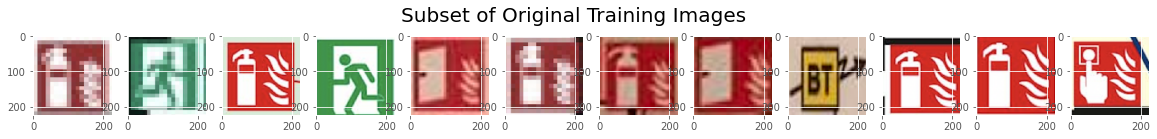

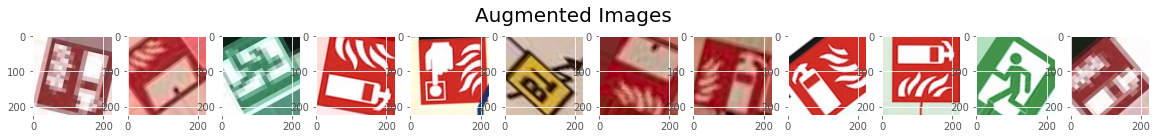

In [12]:
import matplotlib.pyplot as plt

# take subset of training data
train_tensors_subset = train_tensors[:12]

# visualize subset of training data
fig = plt.figure(figsize=(20,2))
for i in range(0, len(train_tensors_subset)):
    ax = fig.add_subplot(1, 12, i+1)
    ax.imshow(train_tensors_subset[i])
fig.suptitle('Subset of Original Training Images', fontsize=20)
plt.savefig('original_images.jpg')

plt.show()

# visualize augmented images
fig = plt.figure(figsize=(20,2))
for x_batch in datagen_train.flow(train_tensors_subset, batch_size=12):
    for i in range(0, 12):
        ax = fig.add_subplot(1, 12, i+1)
        ax.imshow(x_batch[i])
    fig.suptitle('Augmented Images', fontsize=20)
    plt.savefig('augmented_images.jpg')
    plt.show()
    break;

In [ ]:
brand_prediction = brand_names[np.argmax(extended_model_from_scratch.predict(np.expand_dims(test_tensors[j], axis=0)))]
